<a href="https://colab.research.google.com/github/belalabouzaid/siads699_team13_collab/blob/main/SDAP_using_RandomForest_Mariposa(trained).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and using DASK

In [ ]:
pip install "dask[complete]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import os

import matplotlib.pyplot as plt

import joblib


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from dask.distributed import Client
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error as MSE, r2_score, mean_absolute_error as MAE
from yellowbrick.regressor import PredictionError
from sklearn.inspection import permutation_importance
from sklearn.model_selection import learning_curve

RANDOM_STATE= 42

# Creating Drought Function

We are using Mariposa, CA as our region of interest to create the drought function, for the year 2021

In [ ]:
#read the csv file

train_df= pd.read_csv('https://github.com/belalabouzaid/siads699_team13_collab/raw/main/Data/mariposa_2021.csv')
print(train_df.columns)
train_df['smi'] = np.where((train_df['smi'] < 0) ,0, train_df['smi'])
train_df['smi'] = np.where((train_df['smi'] > 1) ,1, train_df['smi'])

# X contains satellite band features and y predictor variable (Soil Moisture Index)

X = train_df.drop(columns=['smi','X','Y', 'SR_B3','SR_B2','SR_B4'],axis= 1)
y = train_df['smi']

print(X.shape,y.shape)

#Split using train test split (training - 75% , test- 25%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state= RANDOM_STATE)
print(X_train.shape, y_train.shape)


# Random Forest Regressor for predicting Soil Moisture Index
regr = RandomForestRegressor(max_depth=18, random_state=42 ,n_jobs=-1).fit(X_train, y_train)


Index(['X', 'Y', 'slope', 'aspect', 'SR_B2', 'NDVI', 'SAVI', 'MNDWI', 'NDMI',
       'SR_B3', 'ST_B10', 'SR_B5', 'EVI', 'SR_B6', 'SR_B7', 'SR_B4', 'MSAVI',
       'MSI', 'smi'],
      dtype='object')
(64541, 13) (64541,)
(48405, 13) (48405,)


In [ ]:
# Predict the model
pred_train= regr.predict(X_train)
pred_test = regr.predict(X_test)

# R2 Computation for Train Dataset
r2_train = r2_score(y_train, pred_train)

# R2 Computation for Test Dataset
r2_test = r2_score(y_test, pred_test)

# min & max SMI for this area
min_smi_test = min(y_test)
max_smi_test = max(y_test)



# MAE , RMSE Computation
mae_test = MAE(y_test, pred_test)
rmse_test = np.sqrt(MSE(y_test, pred_test))

print("R score(TRAIN) : % f" %(r2_train))
print("R score (TEST) : % f" %(r2_test))
print("MAE (TEST): % f" %(mae_test))
print("RMSE (TEST): % f" %(rmse_test))

R score(TRAIN) :  0.960860
R score (TEST) :  0.817399
MAE (TEST):  0.040089
RMSE (TEST):  0.056905


We can see from the above training scores that the model is overfitting so we need to do hyperparameter tuning for the model to generalize well on unseen data.

## Hyperparameter Tuning using GridSearch CV

In [ ]:
client = Client() # start a local Dask client

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:46265
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43133'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45249'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:41323', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:41323
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:45546
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:46017', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:46017
INFO:distributed.core:Sta

In [ ]:
%%time
#using grid search cv to find the optimal parameters , with cross validation= 10

param_grid = { 'max_depth': [18,20],  'min_samples_leaf':[6,8], 'n_estimators':[100,150]}
regr = RandomForestRegressor( random_state= RANDOM_STATE)


with joblib.parallel_backend('dask'):
  g_search = GridSearchCV(estimator = regr, scoring= 'r2', param_grid= param_grid,  n_jobs = -1 ,cv=10)
  g_search.fit(X_train,y_train)


INFO:distributed.utils_perf:full garbage collection released 39.20 MiB from 101 reference cycles (threshold: 9.54 MiB)
INFO:distributed.scheduler:Receive client connection: Client-worker-36e09086-945a-11ee-8388-0242ac1c000c
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:45626
INFO:distributed.scheduler:Receive client connection: Client-worker-36e21a79-945a-11ee-8386-0242ac1c000c
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:45638


CPU times: user 3min 46s, sys: 26.4 s, total: 4min 12s
Wall time: 1h 5min 54s


In [ ]:
# Get the best parameters and the corresponding model
best_params = g_search.best_params_
best_model = g_search.best_estimator_

# Evaluate the model on the test set
y_pred = best_model.predict(X_test)

# Print the default scoring (R^2) on the test set
print("Best Parameters:", best_params)
print("Default Scoring (R^2) Score:", g_search.score(X_test, y_test))

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 6, 'n_estimators': 150}
Default Scoring (R^2) Score: 0.8158346649554055


In [ ]:
best_model

In [ ]:
# after finding the best parameters using Grid Search cv=10, storing the results as best_model
best_model = RandomForestRegressor(max_depth=20, min_samples_leaf=6, n_estimators=150,
                      random_state=42,n_jobs=-1).fit(X_train, y_train)


In [ ]:
# Predict using the best_model

pred_test = best_model.predict(X_test)

# R2 Computation for Test Dataset
r2_test = r2_score(y_test, pred_test)

# min & max SMI for this area
min_smi_test = min(y_test)
max_smi_test = max(y_test)



# MAE , RMSE Computation
mae_test = MAE(y_test, pred_test)
rmse_test = np.sqrt(MSE(y_test, pred_test))

print("R score (TEST) : % f" %(r2_test))
print("MAE (TEST): % f" %(mae_test))
print("RMSE (TEST): % f" %(rmse_test))

R score (TEST) :  0.815835
MAE (TEST):  0.040139
RMSE (TEST):  0.057148


## Feature Importance

Feature Importance refers to technique that calculates a score for all the input features for a given model — the scores simply represent the “importance” of each feature.

Text(0.5, 1.0, 'Visualizing Feature Importances')

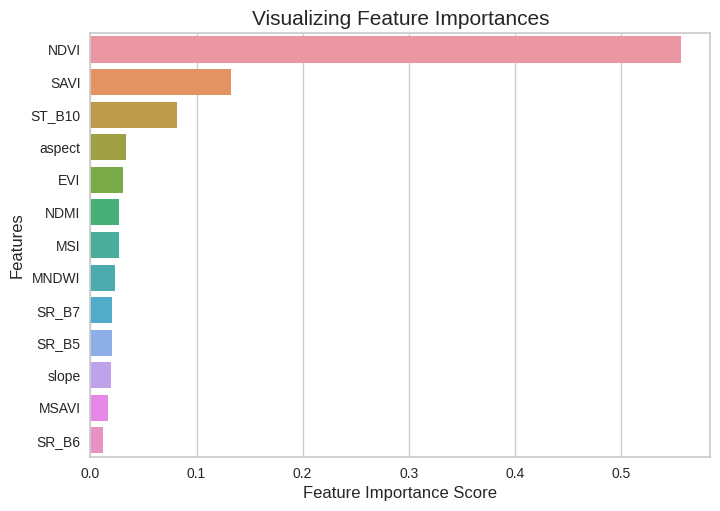

In [ ]:
feature_scores = pd.Series(best_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

round(feature_scores,3)


sns.barplot(x=feature_scores, y=feature_scores.index)
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title("Visualizing Feature Importances", fontsize=15)

## Permutation Importance

Permutation feature importance is another technique to estimate the importance of each feature in a Random Forest model by measuring the change in the model’s performance when the feature’s values are randomly shuffled.

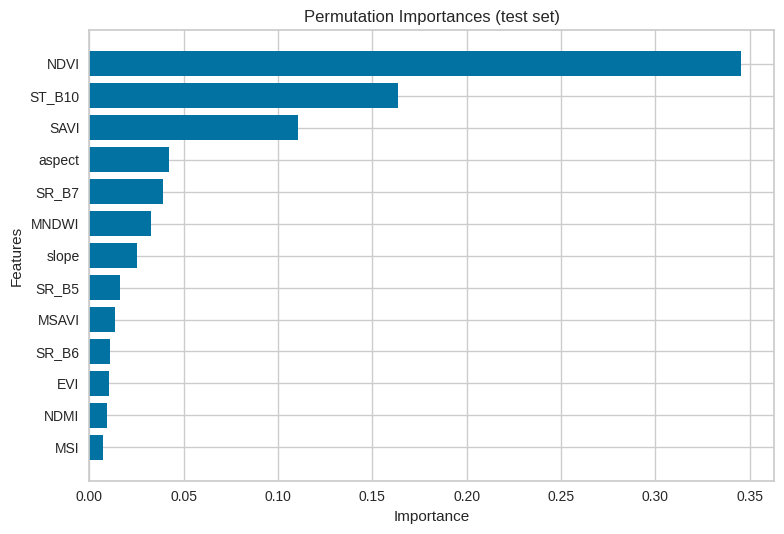

In [ ]:
result = permutation_importance(best_model, X_test, y_test, n_repeats=10,random_state=RANDOM_STATE, n_jobs=-1,scoring='r2')
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.barh(X_test.columns[sorted_idx], result.importances[sorted_idx].mean(axis=1).T)
ax.set_title("Permutation Importances (test set)")
ax.set_xlabel("Importance")
ax.set_ylabel("Features")
fig.tight_layout()
plt.show()

# Validation

## Validating using Dummy Regressor

This regressor is useful as a simple baseline to compare with the(real) Random Forest regressor

In [ ]:
# using dummy regressor on the model to see how it performs

dummy_regr = DummyRegressor(strategy= 'median')
dummy_regr.fit(X_train, y_train)

# Make predictions dummy model
y_pred_dummy = dummy_regr.predict(X_test)


# Calculate Mean Squared Error for dummy model
mae_dummy = MAE(y_test, y_pred_dummy)

r2 = r2_score(y_test,y_pred_dummy)
print("R score : % f" %(r2))
print("MSE : % f" %(mae_dummy))

R score : -0.003561
MSE :  0.103045


In [ ]:
# Function to validate using different areas in CA for drought prediction
def validate_model( regression_model, validation_file):


    # Read the validation dataset
    validation_df = pd.read_csv(validation_file)
    validation_df['smi'] = np.where((validation_df['smi'] < 0) ,0, validation_df['smi'])
    validation_df['smi'] = np.where((validation_df['smi'] > 1) ,1, validation_df['smi'])

    # Separate features and target in the validation dataset
    X_val = validation_df.drop(columns=['smi','X','Y', 'SR_B3','SR_B2','SR_B4'],axis= 1)

    X_val= X_val[X.columns]

    y_val = validation_df['smi']


    # Make predictions on the validation data
    y_val_pred = regression_model.predict(X_val.values)

    # R2 Computation
    r2_val = r2_score(y_val.values, y_val_pred)


    # min & max SMI for this area
    min_smi_val = min(y_val)
    max_smi_val = max(y_val)

    # MSE , RMSE Computation
    mae_val = MAE(y_val.values, y_val_pred)
    rmse_val = np.sqrt(MSE(y_val.values, y_val_pred))

    return (r2_val, rmse_val, mae_val, min_smi_val, max_smi_val, y_val_pred, X_val, y_val)

## Validation region 1 ~ Mariposa,CA

In [ ]:
validation_file = "https://github.com/belalabouzaid/siads699_team13_collab/raw/main/Data/mariposa_2022.csv"

regression_model = best_model



r2_val1,  rmse_val1 , mae_val1, min_smi_val1, max_smi_val1,y_val_pred1, X_val1,y_val1= validate_model(regression_model, validation_file)


print("R score : % f" %(r2_val1))
print("MAE : % f" %(mae_val1))
print("RMSE : % f" %(rmse_val1))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


R score :  0.752096
MAE :  0.043244
RMSE :  0.058144


In [ ]:
# Create a DataFrame
results_df = pd.DataFrame({
    'Metric': ['R-squared', 'RMSE', 'MAE', 'Min_SMI', 'Max_SMI'],
    'Test ~ Mariposa , CA (2021)': [r2_test, rmse_test, mae_test, min_smi_test, max_smi_test],
    'Validation 1 ~ Mariposa, CA (2022)': [r2_val1, rmse_val1, mae_val1, min_smi_val1, max_smi_val1],

})

### Plots for Mariposa, CA

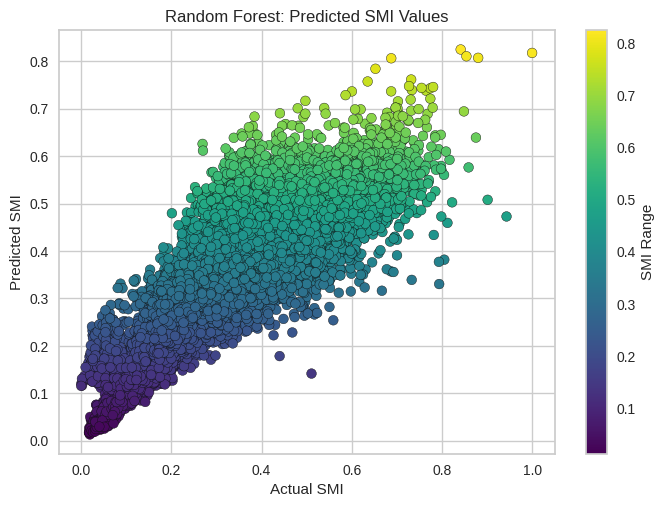

In [ ]:
# Plot predicted SMI values Vs. Actual values
cmap = ListedColormap(['#00FF00', '#FFFF00', '#FF0000'])  # Green to Yellow to Red color map
plt.scatter(y_val1, y_val_pred1, c= y_val_pred1, edgecolors='k', marker='o', cmap='viridis')
plt.colorbar(label='SMI Range')
plt.xlabel('Actual SMI')
plt.ylabel('Predicted SMI')
plt.title('Random Forest: Predicted SMI Values')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


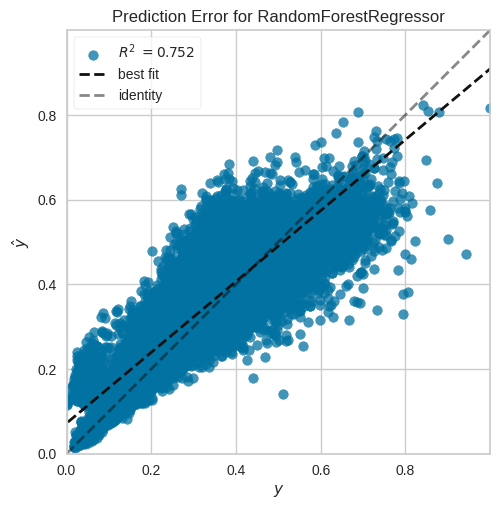

<Axes: title={'center': 'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [ ]:
# Plot Model Error

model= best_model
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val1, y_val1)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [ ]:
#output of actual and predicted smi values (from best_model trained on Mariposa 2021) for Mariposa 2022 - Validation Dataset
#to be used for mapping
mapdf = pd.read_csv(validation_file)[['X','Y']]
mapdf = pd.concat([mapdf, pd.Series(y_val1), pd.Series(y_val_pred1)], axis=1)
mapdf = mapdf.rename(columns={'X':'x','Y':'y', 'smi':'act_smi', 0:'pred_smi'})
mapdf['residual'] = mapdf['act_smi']-mapdf['pred_smi']
mapdf.to_csv("/content/data/mapdf_M_22.csv", index=False)

## Validation region 2 ~ Three Rivers, CA

In [ ]:
validation_file = "https://github.com/belalabouzaid/siads699_team13_collab/raw/main/Data/threerivers_2022.csv"

regression_model = best_model


r2_val2, rmse_val2, mae_val2, min_smi_val2, max_smi_val2, y_val_pred2, X_val2,y_val2 = validate_model(regression_model, validation_file)


print("R score : % f" %(r2_val2))
print("MAE : % f" %(mae_val2))
print("RMSE : % f" %(rmse_val2))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


R score : -5.184017
MAE :  0.075015
RMSE :  0.107268


In [ ]:
# Append metrics for the second set of validation
results_df['Validation 2 ~ Three Rivers, CA (2022)'] = [r2_val2, rmse_val2, mae_val2, min_smi_val2, max_smi_val2]

### Plots for Three Rivers, CA

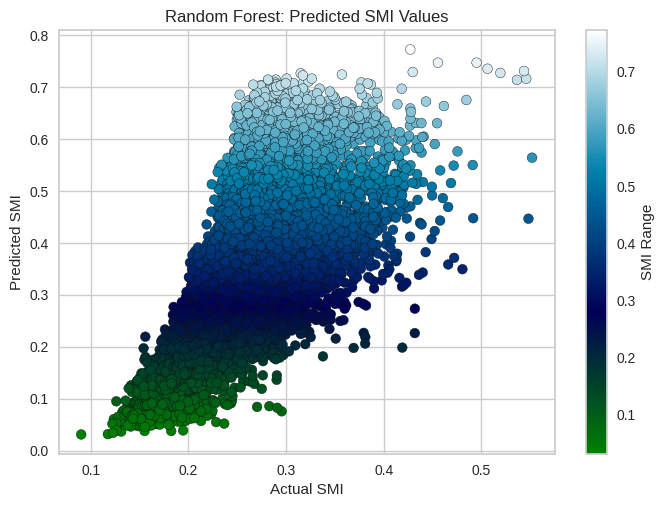

In [ ]:
# Plot predicted SMI values Vs. Actual values
cmap = ListedColormap(['#00FF00', '#FFFF00', '#FF0000'])  # Green to Yellow to Red color map
plt.scatter(y_val2, y_val_pred2, c= y_val_pred2, edgecolors='k', marker='o', cmap='ocean')
plt.colorbar(label='SMI Range')
plt.xlabel('Actual SMI')
plt.ylabel('Predicted SMI')
plt.title('Random Forest: Predicted SMI Values')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


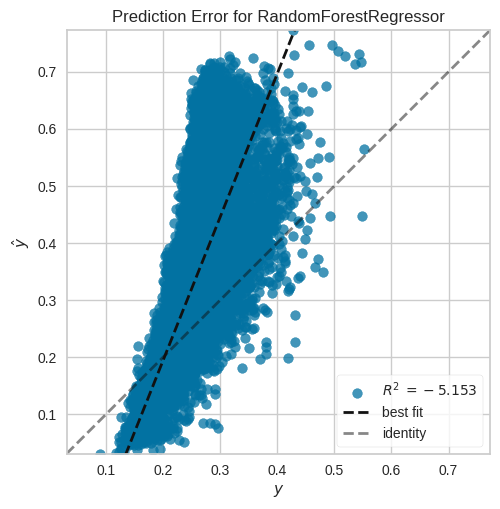

<Axes: title={'center': 'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [ ]:
# Plot Model Error

model= best_model
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val2, y_val2)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [ ]:
#output of actual and predicted smi values (from best_model trained on Mariposa 2021) for Three Rivers 2022 - Validation Dataset
#to be used for mapping
mapdf = pd.read_csv(validation_file)[['X','Y']]
mapdf = pd.concat([mapdf, pd.Series(y_val2), pd.Series(y_val_pred2)], axis=1)
mapdf = mapdf.rename(columns={'X':'x','Y':'y', 'smi':'act_smi', 0:'pred_smi'})
mapdf['residual'] = mapdf['act_smi']-mapdf['pred_smi']
mapdf.to_csv("/content/data/mapdf_3R_22.csv", index=False)

In [ ]:
results_df.transpose()

,0,1,2,3,4
Metric,R-squared,RMSE,MAE,Min_SMI,Max_SMI
"Test ~ Mariposa , CA (2021)",0.815835,0.057148,0.040139,0.006654,0.90678
"Validation 1 ~ Mariposa, CA (2022)",0.752096,0.058144,0.043244,0.0,0.999998
"Validation 2 ~ Three Rivers, CA (2022)",-5.184017,0.107268,0.075015,0.090188,0.551821
